In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transform/scikitlearn/default/1/scaler_x.pkl
/kaggle/input/call-test/calltest.parquet
/kaggle/input/train-data/call_train_data.parquet
/kaggle/input/transformation/scikitlearn/default/1/scaler_x.pkl
/kaggle/input/transformation/scikitlearn/default/1/power_transformer_x.pkl
/kaggle/input/nk-iv-prediction/test_data.parquet
/kaggle/input/nk-iv-prediction/sample_submission.csv
/kaggle/input/nk-iv-prediction/train_data.parquet
/kaggle/input/cleaned-data/call_train1.parquet
/kaggle/input/put-train-data/put_train


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np


2025-06-07 15:52:21.092682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749311541.273520      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749311541.328714      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_parquet('/kaggle/input/train-data')

train.head(5)

train.shape

(4078811, 45)

In [4]:
X_remove = ['X0', 'X4', 'X5', 'X6', 'X7', 'X9', 'X11', 'X13', 'X15', 'X16', 'X20', 'X22', 'X23', 'X25', 'X28', 'X29', 'X30', 'X34', 'X38', 'X39', 'X41']

train.drop(columns = X_remove, inplace = True)

train.shape

(4078811, 24)

In [5]:
from sklearn.model_selection import train_test_split

sampled_df = train.sample(frac=1, random_state=42)

X = sampled_df.drop('iv', axis=1) # Features

Y = sampled_df['iv']               # Target

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


x_train.shape,y_train.shape,x_test.shape,y_test.shape

((3263048, 23), (3263048,), (815763, 23), (815763,))

In [6]:
standard_scale = StandardScaler()
x_train = standard_scale.fit_transform(x_train)
x_test = standard_scale.transform(x_test)

In [7]:
x_train.shape

(3263048, 23)

In [8]:
x_train.mean()

3.997374399014415e-16

In [9]:
print(x_train.mean())
x_test.mean()

3.997374399014415e-16


0.0003143721949817589

In [10]:
y_train.max() - y_train.min()

0.6393545

In [11]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

y_train_np = y_train_np.reshape(-1, 1).astype(np.float32)
y_test_np = y_test_np.reshape(-1, 1).astype(np.float32)

print(x_train_np.shape)
print(y_train_np.shape)

(3263048, 23)
(3263048, 1)


In [12]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow detected {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU detected by TensorFlow.")


TensorFlow detected 1 GPU(s):
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU, ReLU
from tensorflow.keras.initializers import HeNormal


def build_mlp_regressor(input_dim, hidden_layers=[60], output_dim=1, dropout_rates=[0.4]):
    assert len(hidden_layers) == len(dropout_rates), "Length of hidden_layers and dropout_rates must match"

    model = Sequential()
    initializer = HeNormal()

    # Input
    model.add(Input(shape=(input_dim,)))
    #model.add(BatchNormalization())

    # Hidden layers
    for units, rate in zip(hidden_layers, dropout_rates):
        model.add(Dense(units, kernel_initializer=initializer))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(rate))  # 🔄 Apply each dropout rate per layer

    # Output layer
    model.add(Dense(output_dim, kernel_initializer=initializer))

    return model


In [ ]:

from tensorflow.keras.optimizers import Adam
with tf.device('/GPU:0'):
    model = build_mlp_regressor(input_dim=x_train_np.shape[1])

    custom_lr = 0.001  # Example: set to your desired value
    optimizer = Adam(learning_rate=custom_lr)
    
    model.compile(optimizer= optimizer, loss='mse')
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=1e-5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        x_train_np, y_train_np,
        validation_data=(x_test_np, y_test_np),
        epochs=100,
        batch_size=500,
        callbacks = [early_stopping],
        verbose=1
    ) 

Epoch 1/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.2928 - val_loss: 0.0075
Epoch 2/100
3407/6527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0078

In [18]:
df_call.isna().sum()

x_input = df_call.drop(columns = ['iv']+ X_remove)


x_input = StandardScaler().fit_transform(x_input)
print(x_input.mean())
y_input = df_call['iv']

import numpy as np

# If not already NumPy arrays:
x_input = np.array(x_input)
y_input = np.array(y_input)

y_input = y_input.reshape(-1, 1)

predictions = model.predict(x_input)


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_input, predictions)
print("MSE on x_input:", mse)


9.44732996651897e-16
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
MSE on x_input: 0.004774102429979447


In [41]:
y_input.max() - y_input.min()

0.32889899999999994

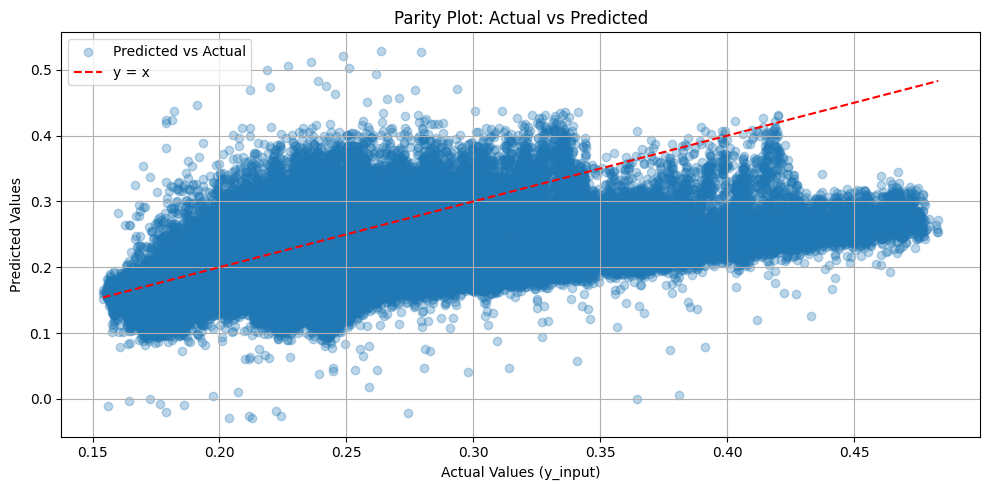

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten in case they are shaped (n, 1)
y_input = y_input.flatten()
predictions = predictions.flatten()

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_input, predictions, alpha=0.3, label='Predicted vs Actual')
plt.plot([y_input.min(), y_input.max()], [y_input.min(), y_input.max()], 'r--', label='y = x')
plt.xlabel('Actual Values (y_input)')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
df_call.isna().sum()

x_input = df_call.drop(columns = ['iv']+ X_remove)




y_input = df_call['iv']

import numpy as np

# If not already NumPy arrays:
x_input = np.array(x_input)
y_input = np.array(y_input)

y_input = y_input.reshape(-1, 1)

predictions = xgb_model.predict(x_input)


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_input, predictions)
print("MSE on x_input:", mse)


NameError: name 'xgb_model' is not defined

In [ ]:
model.save("/kaggle/working/call_mlp_model2.h5")

In [16]:
test = pd.read_parquet('/kaggle/input/nk-iv-prediction/test_data.parquet')
test.head(5)

test.drop(columns = ['timestamp'],  inplace = True)
test.head()

call = []
for col in test.columns.tolist() :
    if 'call' in col:
        call.append(col)
    else:
        continue
len(call)

put = []
for col in test.columns.tolist() :
    if 'put' in col:
        put.append(col)
    else:
        continue
len(put)  

k_call = []
for col in call:
    col.split('iv')[1]
    k_call.append(col.split('iv')[1].split('_')[1])
len(k_call)

call_test = test.drop(columns = put)
call_test.shape


all_values = []
modified = call_test[call]
for i in range(len(modified)):
    value = modified.iloc[i].tolist()  # 26 values
    all_values.extend(value)
len(all_values)

base_call = call_test.drop(columns = call)
base_call.shape

repeated_indices = np.repeat(base_call.index.values, 26)
expanded_col_call = base_call.loc[repeated_indices].reset_index(drop=True)

expanded_col_call['k'] = k_call * len(base_call)

expanded_col_call.shape

expanded_col_call['iv'] = all_values

expanded_col_call.head(27)

expanded_col_call['k'] = expanded_col_call['k'].astype(float)

import numpy as np

# Replace None with np.nan
expanded_col_call['iv'] = expanded_col_call['iv'].replace({'None': np.nan})

not_nan_rows = expanded_col_call[expanded_col_call['iv'].notna()]
not_nan_rows.head(10)
df_call = not_nan_rows
nan_rows = expanded_col_call[expanded_col_call['iv'].isna()]
new_df_call = nan_rows
new_df_call.head(10)
print(new_df_call.shape)
df_call.shape


df_call.isna().sum()


(188055, 45)


underlying    0
X0            0
X1            0
X2            0
X3            0
X4            0
X5            0
X6            0
X7            0
X8            0
X9            0
X10           0
X11           0
X12           0
X13           0
X14           0
X15           0
X16           0
X17           0
X18           0
X19           0
X20           0
X21           0
X22           0
X23           0
X24           0
X25           0
X26           0
X27           0
X28           0
X29           0
X30           0
X31           0
X32           0
X33           0
X34           0
X35           0
X36           0
X37           0
X38           0
X39           0
X40           0
X41           0
k             0
iv            0
dtype: int64

In [ ]:
!nvidia-smi


In [ ]:
put_train = pd.read_parquet('/kaggle/input/put-train-data')

put_train.shape

col = 'iv'
Q1 = put_train[col].quantile(0.25)
Q3 = put_train[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask for outliers
outliers_mask = (put_train[col] < lower_bound) | (put_train[col] > upper_bound)




# Calculate percentage
percent_outliers = outliers_mask.mean() * 100

print(f"Percentage of outliers in '{col}': {percent_outliers:.2f}%")

put_train_no_outliers = put_train[(put_train['iv'] >= lower_bound) & (put_train['iv'] <= upper_bound)]
print(f"Original data size: {put_train.shape[0]}")
print(f"Data size after removing outliers: {put_train_no_outliers.shape[0]}")


put_train = put_train_no_outliers
put_train.shape

In [ ]:
X_remove = ['X0', 'X4', 'X5', 'X6', 'X7', 'X9', 'X11', 'X13', 'X15', 'X16', 'X20', 'X22', 'X23', 'X25', 'X28', 'X29', 'X30', 'X34', 'X38', 'X39', 'X41']

put_train.drop(columns = X_remove, inplace = True)

put_train.shape

In [ ]:
from sklearn.model_selection import train_test_split

sampled_df = put_train.sample(frac=0.1, random_state=42)

X = sampled_df.drop('iv', axis=1) # Features

Y = sampled_df['iv']               # Target

put_x_train, put_x_test, put_y_train, put_y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


put_x_train.shape,put_y_train.shape,put_x_test.shape,put_y_test.shape

In [ ]:
scaler_put = StandardScaler()
put_x_train = scaler_put.fit_transform(put_x_train)
put_x_test =  scaler_put.transform(put_x_test)

put_x_test.mean()
put_x_train.mean()


put_x_train_np = np.array(put_x_train)
put_y_train_np = np.array(put_y_train)

put_x_test_np = np.array(put_x_test)
put_y_test_np = np.array(put_y_test)

put_y_train_np = put_y_train_np.reshape(-1, 1).astype(np.float32)
put_y_test_np = put_y_test_np.reshape(-1, 1).astype(np.float32)

print(put_x_train_np.shape)
print(put_y_train_np.shape)

In [ ]:
print(put_x_test.mean())
print(put_x_train.mean())


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.initializers import HeNormal

def build_mlp_regressor_put(input_dim, hidden_layers=[200,150,100], output_dim=1, dropout_rate=0.4):
    model1 = Sequential()
    initializer = HeNormal()

    # Input layer
    model1.add(Input(shape=(input_dim,)))
    model1.add(BatchNormalization())

    # Hidden layers
    for i, units in enumerate(hidden_layers):
        model1.add(Dense(units, kernel_initializer=initializer))
        model1.add(BatchNormalization())
        model1.add(LeakyReLU())
        #if i == 0:  # Only apply dropout to the first hidden layer
        model1.add(Dropout(dropout_rate))

    # Output layer
    model1.add(Dense(output_dim, kernel_initializer=initializer))

    return model1


In [ ]:

with tf.device('/GPU:0'):
    model1 = build_mlp_regressor_put(input_dim=put_x_train_np.shape[1])
    
    model1.compile(optimizer='adam', loss='mse')
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=1e-5, restore_best_weights=True)
    
    # Train the model
    history = model1.fit(
        put_x_train_np, put_y_train_np,
        validation_data=(put_x_test_np, put_y_test_np),
        epochs=100,
        batch_size=500,
        callbacks = [early_stopping],
        verbose=1
    ) 

In [ ]:
# test error
x_put_input = df.drop(columns = ['iv']+X_remove)
x_put_input = StandardScaler().fit_transform(x_put_input)
print(x_put_input.mean())

y_input_put = df['iv']

import numpy as np

# If not already NumPy arrays:
x_put_input = np.array(x_put_input)
y_put_input = np.array(y_input_put)

y_put_input = y_put_input.reshape(-1, 1)

predictions_put = model1.predict(x_put_input)


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_put_input, predictions_put)
print("MSE on x_input:", mse)


In [ ]:
model1.save("/kaggle/working/put_mlp_model.h5")

In [ ]:

test = pd.read_parquet('/kaggle/input/nk-iv-prediction/test_data.parquet')
test.drop(columns = ['timestamp'],  inplace = True)
test.head()

put_test = test.drop(columns = call)
put_test.shape


all_values_put = []
modified = put_test[put]
for i in range(len(modified)):
    value = modified.iloc[i].tolist()  # 26 values
    all_values_put.extend(value)
len(all_values_put)

base_put = put_test.drop(columns = put)
base_put.shape

repeated_indices = np.repeat(base_put.index.values, 26)
expanded_col_put = base_put.loc[repeated_indices].reset_index(drop=True)

k_put = []
for col in put:
    col.split('iv')[1]
    k_put.append(col.split('iv')[1].split('_')[1])
len(k_put)

expanded_col_put['k'] = k_put * len(base_put)

expanded_col_put.shape

expanded_col_put['iv'] = all_values_put

expanded_col_put['k'] = expanded_col_put['k'].astype(float)

import numpy as np

# Replace None with np.nan
expanded_col_put['iv'] = expanded_col_put['iv'].replace({'None': np.nan})

not_nan_rows = expanded_col_put[expanded_col_put['iv'].notna()]
not_nan_rows.head(10)
df = not_nan_rows
nan_rows = expanded_col_put[expanded_col_put['iv'].isna()]
new_df = nan_rows
new_df.head(10)
print(new_df.shape)
df.shape